In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import make_prior_knowledge
print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])
np.set_printoptions(precision=3, suppress=True)
np.random.seed(100)
from datetime import datetime


['1.23.4', '2.0.0', '0.20.1', '1.7.1']


In [2]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x[1]' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d


In [3]:
projects = pd.read_csv('Kickstarter Campaigns DataSet.csv', sep=',',encoding='latin1')
print(projects.columns)
print(projects.head())


Index(['Unnamed: 0', 'id', 'name', 'currency', 'launched_at', 'backers_count',
       'blurb', 'country', 'deadline', 'slug', 'status', 'usd_pledged',
       'sub_category', 'main_category', 'creator_id', 'blurb_length',
       'goal_usd', 'city', 'duration'],
      dtype='object')
   Unnamed: 0          id                                               name   
0           0  1714728788      Urban Farm Kits: Our Solution to City Farming  \
1           1  1639965256               Reflections on the LHC Safety Report   
2           2  1582062943                        Ultra-Custom Chocolate Bars   
3           3  1888984372                      GlassWeb: Internet Monitoring   
4           4  1409770586  Dreaming of Streaming - 96.9 FM KMRD-LP Madrid...   

  currency          launched_at  backers_count   
0      CAD  2018-02-10 22:47:52             16  \
1      USD  2014-11-21 10:42:26              7   
2      USD  2020-10-19 05:26:59             99   
3      USD  2019-05-29 16:01:34     

In [4]:
# check number of rows remaining
print ("There are {} rows in the datset ".format(len(projects)))
projects=projects.drop(['Unnamed: 0'], axis=1)
print("duplicates: ", projects.duplicated().sum())
projects.drop_duplicates(inplace=True, ignore_index=True)

# original row-length was 217245. check after removal of duplicates
print("length of dataset after removal of duplicates is ", len(projects))

There are 217245 rows in the datset 
duplicates:  19527
length of dataset after removal of duplicates is  197718


In [5]:
# Check missings
print(projects.isnull().sum())

#drop columns
projects=projects.drop(columns=['launched_at', 'blurb',  'deadline', 'id', 'name','currency','slug','creator_id','backers_count','usd_pledged'],axis=1)
#projects=projects.drop(columns=['Unnamed: 0', 'id', 'name','currency','slug','usd_pledged','sub_category','creator_id'],axis=1)

print(projects.columns)
print(projects.head())

id               0
name             0
currency         0
launched_at      0
backers_count    0
blurb            0
country          0
deadline         0
slug             0
status           0
usd_pledged      0
sub_category     0
main_category    0
creator_id       0
blurb_length     0
goal_usd         0
city             0
duration         0
dtype: int64
Index(['country', 'status', 'sub_category', 'main_category', 'blurb_length',
       'goal_usd', 'city', 'duration'],
      dtype='object')
  country      status sub_category     main_category  blurb_length   
0      CA      failed         food             Farms           122  \
1      US  successful   publishing          Academic            35   
2      US  successful         food       Small Batch           122   
3      US      failed   technology           Gadgets            69   
4      US  successful   publishing  Radio & Podcasts           131   

      goal_usd          city  duration  
0    785.82065      Victoria      60.0  
1  

In [6]:
projects['status'].value_counts()

status
successful    109205
failed         75694
canceled        9284
live            3535
Name: count, dtype: int64

In [7]:
projects=projects[projects.status!='canceled']
projects=projects[projects.status!='live']

In [8]:
projects['status'].value_counts()

status
successful    109205
failed         75694
Name: count, dtype: int64

In [9]:
print("The projects are divided into {} different main categories".format(projects['main_category'].nunique()))
print("They are also divided into {} different sub-categories".format(projects['sub_category'].nunique()))
print("They are also divided into {} different city".format(projects['city'].nunique()))
print("They are also divided into {} different country".format(projects['country'].nunique()))


The projects are divided into 159 different main categories
They are also divided into 15 different sub-categories
They are also divided into 12871 different city
They are also divided into 25 different country


In [10]:
#modifying data
projects["status"]= np.where(projects['status']=='successful', 1, 0)

projects['city']=projects['city'].astype('category')
projects['city']=projects['city'].cat.codes
projects['main_category']=projects['main_category'].astype('category')
projects['main_category']=projects['main_category'].cat.codes
projects['country']=projects['country'].astype('category')
projects['country']=projects['country'].cat.codes
projects['sub_category']=projects['sub_category'].astype('category')
projects['sub_category']=projects['sub_category'].cat.codes
print(projects.head())
print(projects.columns)

   country  status  sub_category  main_category  blurb_length     goal_usd   
0        3       0             7             50           122    785.82065  \
1       24       1            12              1            35     93.00000   
2       24       1             7            128           122   1500.00000   
3       24       0            13             60            69  25000.00000   
4       24       1            12            118           131   5000.00000   

    city  duration  
0  11903      60.0  
1   9890      24.0  
2   8849      30.0  
3   2406      60.0  
4   6828      30.0  
Index(['country', 'status', 'sub_category', 'main_category', 'blurb_length',
       'goal_usd', 'city', 'duration'],
      dtype='object')


In [11]:

projects['goal_usd']=np.log(projects['goal_usd'])

print(np.isinf(projects).values.sum())

0


In [12]:
print(projects.head())
print(projects.columns)

   country  status  sub_category  main_category  blurb_length   goal_usd   
0        3       0             7             50           122   6.666729  \
1       24       1            12              1            35   4.532599   
2       24       1             7            128           122   7.313220   
3       24       0            13             60            69  10.126631   
4       24       1            12            118           131   8.517193   

    city  duration  
0  11903      60.0  
1   9890      24.0  
2   8849      30.0  
3   2406      60.0  
4   6828      30.0  
Index(['country', 'status', 'sub_category', 'main_category', 'blurb_length',
       'goal_usd', 'city', 'duration'],
      dtype='object')


dealing with outliers

In [13]:
# check number of rows remaining
print ("There are {} rows in the datset before outlier removal".format(len(projects)))

There are 184899 rows in the datset before outlier removal


In [14]:
# outliers:
low_outs = len(projects[(projects['goal_usd'] <= 0)])
print ("There are {} low outliers".format(low_outs))

high_outs = len(projects[(projects['goal_usd'] >15)])
print ("There are {} high outliers".format(high_outs))
projects.drop(projects[(projects['goal_usd'] <= 0) | (projects['goal_usd'] > 15)].index, axis=0, inplace=True)

There are 245 low outliers
There are 167 high outliers


In [15]:
# check number of rows remaining
print ("There are {} rows in the datset after outlier removal".format(len(projects)))

There are 184487 rows in the datset after outlier removal


Causal Discovery

In [18]:
print(projects.columns)

Index(['country', 'status', 'sub_category', 'main_category', 'blurb_length',
       'goal_usd', 'city', 'duration'],
      dtype='object')


In [19]:
pk = make_prior_knowledge(n_variables=len(projects.columns),sink_variables=[1])


['[i]. country', '[i]. status', '[i]. sub_category', '[i]. main_category', '[i]. blurb_length', '[i]. goal_usd', '[i]. city', '[i]. duration']
digraph {
	"[i]. goal_usd" -> "[i]. status" [label=-0.06]
	"[i]. country" -> "[i]. sub_category" [label=-0.01]
	"[i]. blurb_length" -> "[i]. sub_category" [label=0.01]
	"[i]. sub_category" -> "[i]. main_category" [label=0.62]
	"[i]. blurb_length" -> "[i]. main_category" [label=0.06]
	"[i]. country" -> "[i]. blurb_length" [label=0.18]
	"[i]. country" -> "[i]. goal_usd" [label=0.01]
	"[i]. sub_category" -> "[i]. goal_usd" [label=0.06]
	"[i]. duration" -> "[i]. goal_usd" [label=0.03]
	"[i]. country" -> "[i]. city" [label=-14.32]
	"[i]. sub_category" -> "[i]. duration" [label=0.22]
	"[i]. blurb_length" -> "[i]. duration" [label=0.01]
}



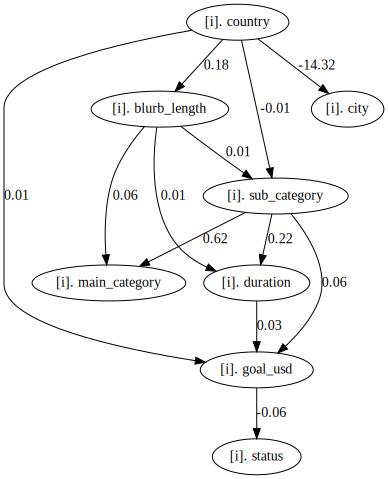

In [20]:
model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(projects)
labels = [f'[i]. {col}' for i, col in enumerate(projects.columns)]
print(labels)
dot = make_graph(model.adjacency_matrix_, labels)
print(dot)
dot

In [42]:
from sklearn.linear_model import LogisticRegression
target = 1 # status
features = [i for i in range(projects.shape[1]) if i != target]
reg = LogisticRegression(solver='liblinear')
reg.fit(projects.iloc[:, features].values, projects.iloc[:, target].values)
ce = lingam.CausalEffect(model)
effects = ce.estimate_effects_on_prediction(projects.values, target, reg)
df_effects = pd.DataFrame()
df_effects['feature'] = projects.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,country,0.092898,0.095668
1,status,0.000000,0.000000
2,sub_category,0.022852,0.023016
3,main_category,0.010373,0.010340
4,blurb_length,0.081510,0.083634
5,goal_usd,0.098204,0.095288
6,city,0.069094,0.070614
7,duration,0.087141,0.084837


Dropping City

In [24]:
projects1=projects.drop(columns=['city'],axis=1)

['[i]. country', '[i]. status', '[i]. sub_category', '[i]. main_category', '[i]. blurb_length', '[i]. goal_usd', '[i]. duration']
digraph {
	"[i]. goal_usd" -> "[i]. status" [label=-0.06]
	"[i]. country" -> "[i]. sub_category" [label=-0.01]
	"[i]. blurb_length" -> "[i]. sub_category" [label=0.01]
	"[i]. sub_category" -> "[i]. main_category" [label=0.62]
	"[i]. blurb_length" -> "[i]. main_category" [label=0.06]
	"[i]. country" -> "[i]. blurb_length" [label=0.18]
	"[i]. country" -> "[i]. goal_usd" [label=0.01]
	"[i]. sub_category" -> "[i]. goal_usd" [label=0.06]
	"[i]. duration" -> "[i]. goal_usd" [label=0.03]
	"[i]. sub_category" -> "[i]. duration" [label=0.22]
	"[i]. blurb_length" -> "[i]. duration" [label=0.01]
}



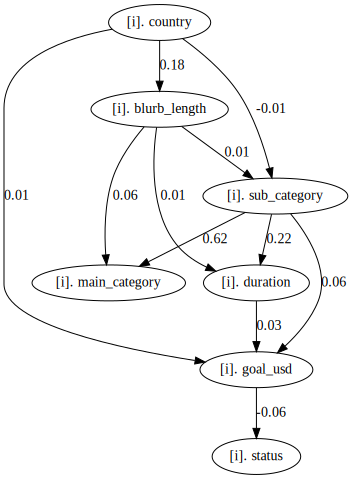

In [27]:
pk1 = make_prior_knowledge(n_variables=len(projects1.columns),sink_variables=[1])
model1 = lingam.DirectLiNGAM(prior_knowledge=pk1)
model1.fit(projects1)
labels1 = [f'[i]. {col}' for i, col in enumerate(projects1.columns)]
print(labels1)
dot1 = make_graph(model1.adjacency_matrix_, labels1)
print(dot1)
dot1

In [44]:
from sklearn.linear_model import LogisticRegression
target = 1 # status
features = [i for i in range(projects1.shape[1]) if i != target]
reg = LogisticRegression(solver='liblinear')
reg.fit(projects1.iloc[:, features].values, projects1.iloc[:, target].values)
ce = lingam.CausalEffect(model1)
effects = ce.estimate_effects_on_prediction(projects1.values, target, reg)
df_effects = pd.DataFrame()
df_effects['feature'] = projects1.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,country,0.009408,0.009444
1,status,0.000000,0.000000
2,sub_category,0.036754,0.036211
3,main_category,0.064087,0.062452
4,blurb_length,0.043748,0.042980
5,goal_usd,0.237879,0.216810
6,duration,0.183571,0.170765


Dropping main category

In [28]:
projects2=projects.drop(columns='main_category',axis=1)

['[i]. country', '[i]. status', '[i]. sub_category', '[i]. blurb_length', '[i]. goal_usd', '[i]. city', '[i]. duration']
digraph {
	"[i]. goal_usd" -> "[i]. status" [label=-0.06]
	"[i]. country" -> "[i]. sub_category" [label=-0.01]
	"[i]. blurb_length" -> "[i]. sub_category" [label=0.01]
	"[i]. country" -> "[i]. blurb_length" [label=0.18]
	"[i]. country" -> "[i]. goal_usd" [label=0.01]
	"[i]. sub_category" -> "[i]. goal_usd" [label=0.06]
	"[i]. duration" -> "[i]. goal_usd" [label=0.03]
	"[i]. country" -> "[i]. city" [label=-14.32]
	"[i]. sub_category" -> "[i]. duration" [label=0.22]
	"[i]. blurb_length" -> "[i]. duration" [label=0.01]
}



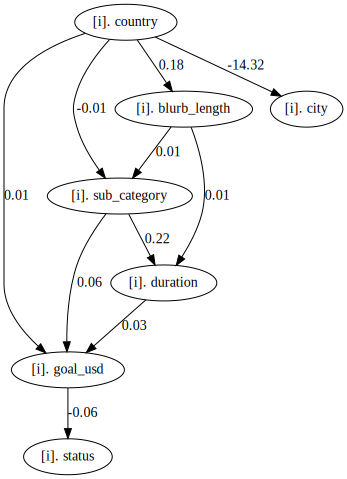

In [31]:
pk2 = make_prior_knowledge(n_variables=len(projects2.columns),sink_variables=[1])
model2 = lingam.DirectLiNGAM(prior_knowledge=pk2)
model2.fit(projects2)
labels2 = [f'[i]. {col}' for i, col in enumerate(projects2.columns)]
print(labels2)
dot2 = make_graph(model2.adjacency_matrix_, labels2)
print(dot2)
dot2

In [45]:
from sklearn.linear_model import LogisticRegression
target = 1 # status
features = [i for i in range(projects2.shape[1]) if i != target]
reg = LogisticRegression(solver='liblinear')
reg.fit(projects2.iloc[:, features].values, projects2.iloc[:, target].values)
ce = lingam.CausalEffect(model2)
effects = ce.estimate_effects_on_prediction(projects2.values, target, reg)
df_effects = pd.DataFrame()
df_effects['feature'] = projects2.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,country,0.041547,0.042190
1,status,0.000000,0.000000
2,sub_category,0.018254,0.018133
3,blurb_length,0.005435,0.005446
4,goal_usd,0.197387,0.184050
5,city,0.027366,0.027644
6,duration,0.144024,0.136791


Dropping main category and city

In [32]:
projects4=projects.drop(columns=['main_category','city'],axis=1)

['[i]. country', '[i]. status', '[i]. sub_category', '[i]. blurb_length', '[i]. goal_usd', '[i]. duration']
digraph {
	"[i]. goal_usd" -> "[i]. status" [label=-0.06]
	"[i]. country" -> "[i]. sub_category" [label=-0.01]
	"[i]. blurb_length" -> "[i]. sub_category" [label=0.01]
	"[i]. country" -> "[i]. blurb_length" [label=0.18]
	"[i]. country" -> "[i]. goal_usd" [label=0.01]
	"[i]. sub_category" -> "[i]. goal_usd" [label=0.06]
	"[i]. duration" -> "[i]. goal_usd" [label=0.03]
	"[i]. sub_category" -> "[i]. duration" [label=0.22]
	"[i]. blurb_length" -> "[i]. duration" [label=0.01]
}



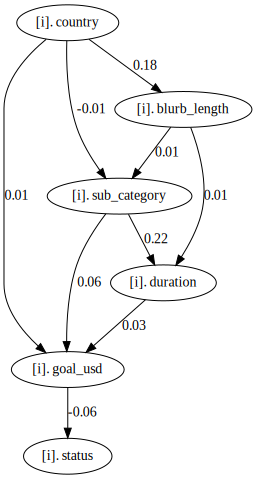

In [35]:
pk4 = make_prior_knowledge(n_variables=len(projects4.columns),sink_variables=[1])
model4 = lingam.DirectLiNGAM(prior_knowledge=pk4)
model4.fit(projects4)
labels4 = [f'[i]. {col}' for i, col in enumerate(projects4.columns)]
print(labels4)
dot4 = make_graph(model4.adjacency_matrix_, labels4)
print(dot4)
dot4

In [46]:
from sklearn.linear_model import LogisticRegression
target = 1 # status
features = [i for i in range(projects4.shape[1]) if i != target]
reg = LogisticRegression(solver='liblinear')
reg.fit(projects4.iloc[:, features].values, projects4.iloc[:, target].values)
ce = lingam.CausalEffect(model4)
effects = ce.estimate_effects_on_prediction(projects4.values, target, reg)
df_effects = pd.DataFrame()
df_effects['feature'] = projects4.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,country,0.009230,0.009265
1,status,0.000000,0.000000
2,sub_category,0.036429,0.035896
3,blurb_length,0.043342,0.042590
4,goal_usd,0.239501,0.218217
5,duration,0.183871,0.171062
